In [1]:
import pandas as pd
import numpy as np
import os
import glob
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
def preprocess_data(data, is_train=True):
    
    temp = data.copy()
    temp = temp[['Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']]

    if is_train==True:          
    
        temp['Target1'] = temp['TARGET'].shift(-48).fillna(method='ffill')
        temp['Target2'] = temp['TARGET'].shift(-48*2).fillna(method='ffill')
        temp = temp.dropna()
        
        return temp.iloc[:-96]

    elif is_train==False:
        
        temp = temp[['Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']]
                              
        return temp.iloc[-48:, :]

In [3]:
train = pd.read_csv('./data/train/train.csv')

test = []

for i in range(81):
    file_path = './data/test/' + str(i) + '.csv'
    temp = pd.read_csv(file_path)
    temp = preprocess_data(temp, is_train=False)
    test.append(temp)

df_test = pd.concat(test)

submission = pd.read_csv('./data/sample_submission.csv')

In [4]:
df_train = preprocess_data(train)

df_train.shape, df_test.shape

((52464, 9), (3888, 7))

In [5]:
df_train.WS = np.log1p(df_train.WS)
df_test.WS = np.log1p(df_test.WS)

In [6]:
min = df_train[['Hour','DHI','DNI','WS','RH','T']].min()
max  = df_train[['Hour','DHI','DNI','WS','RH','T']].max()

In [7]:
for i, col in enumerate(['Hour','DHI','DNI','WS','RH','T']):
    df_train[col] = (df_train[col] - min[i]) / (max[i] - min[i])
    df_test[col] = (df_test[col] - min[i]) / (max[i] - min[i])

In [8]:
Day  = df_train.iloc[:, :-2]
Day7 = df_train.iloc[:, -2]
Day8 = df_train.iloc[:, -1]
Day78 = df_train.iloc[:, -2:]

In [9]:
def quantile_loss(q, y, pred):
    err = (y-pred)
    return mean(maximum(q*err, (q-1)*err), axis=-1)

In [10]:
q_lst = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid = train_test_split(Day, Day78, test_size=0.25, random_state=42)

X_train_1, X_valid_1, Y_train_1, Y_valid_1 = train_test_split(Day, Day7, test_size=0.25, random_state=42)
X_train_2, X_valid_2, Y_train_2, Y_valid_2 = train_test_split(Day, Day8, test_size=0.25, random_state=42)

X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape

((39348, 7), (13116, 7), (39348, 2), (13116, 2))

In [12]:
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras import layers
from tensorflow.keras.backend import mean, maximum

tf.random.set_seed(42)

epoch = 100

In [13]:
model = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(Day.shape)),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(2)
])

model.compile(loss='mse', optimizer='adam')
hist = model.fit(X_train, Y_train, epochs=epoch, batch_size=48, validation_split=0.25, 
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
model.evaluate(X_valid, Y_valid)

Epoch 1/100
615/615 [==============================] - 1s 2ms/step - loss: 367.3883 - val_loss: 178.8931
Epoch 2/100
615/615 [==============================] - 1s 1ms/step - loss: 171.6994 - val_loss: 158.0998
Epoch 3/100
615/615 [==============================] - 1s 1ms/step - loss: 153.0226 - val_loss: 150.6760
Epoch 4/100
615/615 [==============================] - 1s 1ms/step - loss: 154.1150 - val_loss: 148.6838
Epoch 5/100
615/615 [==============================] - 1s 1ms/step - loss: 148.2095 - val_loss: 147.8098
Epoch 6/100
615/615 [==============================] - 1s 1ms/step - loss: 150.1184 - val_loss: 149.6413
Epoch 7/100
615/615 [==============================] - 1s 1ms/step - loss: 149.8693 - val_loss: 146.2519
Epoch 8/100
615/615 [==============================] - 1s 1ms/step - loss: 142.4574 - val_loss: 147.2933
Epoch 9/100
615/615 [==============================] - 1s 1ms/step - loss: 148.2808 - val_loss: 146.2809
Epoch 10/100
615/615 [==============================] -

136.9035186767578

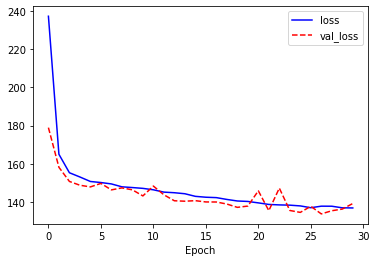

In [14]:
plt.plot(hist.history['loss'], 'b-', label='loss')
plt.plot(hist.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [15]:
results = pd.DataFrame()

for q in q_lst:
    model.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model.fit(Day, Day78, epochs=epoch, batch_size=48, validation_split=0.25, 
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
    pred = pd.DataFrame(model.predict(df_test))
    results = pd.concat([results, pred], axis=1)

results.shape

Epoch 1/100
820/820 [==============================] - 1s 1ms/step - loss: 1.4466 - val_loss: 1.5857
Epoch 2/100
820/820 [==============================] - 1s 1ms/step - loss: 1.4015 - val_loss: 1.5911
Epoch 3/100
820/820 [==============================] - 1s 1ms/step - loss: 1.3885 - val_loss: 1.5875
Epoch 4/100
820/820 [==============================] - 1s 1ms/step - loss: 1.3851 - val_loss: 1.5817
Epoch 5/100
820/820 [==============================] - 1s 1ms/step - loss: 1.3950 - val_loss: 1.5888
Epoch 6/100
820/820 [==============================] - 1s 1ms/step - loss: 1.3919 - val_loss: 1.5936
Epoch 7/100
820/820 [==============================] - 1s 1ms/step - loss: 1.3963 - val_loss: 1.5751
Epoch 8/100
820/820 [==============================] - 1s 1ms/step - loss: 1.4032 - val_loss: 1.5890
Epoch 9/100
820/820 [==============================] - 1s 1ms/step - loss: 1.3972 - val_loss: 1.5817
Epoch 10/100
820/820 [==============================] - 1s 1ms/step - loss: 1.4083 - val_lo

Epoch 4/100
820/820 [==============================] - 1s 1ms/step - loss: 2.7447 - val_loss: 3.1620
Epoch 00004: early stopping
Epoch 1/100
820/820 [==============================] - 2s 1ms/step - loss: 2.6437 - val_loss: 2.9995
Epoch 2/100
820/820 [==============================] - 1s 1ms/step - loss: 2.6233 - val_loss: 3.0241
Epoch 3/100
820/820 [==============================] - 1s 1ms/step - loss: 2.6223 - val_loss: 3.0258
Epoch 4/100
820/820 [==============================] - 1s 1ms/step - loss: 2.6248 - val_loss: 3.0458
Epoch 00004: early stopping
Epoch 1/100
820/820 [==============================] - 2s 2ms/step - loss: 2.3431 - val_loss: 2.6631
Epoch 2/100
820/820 [==============================] - 1s 1ms/step - loss: 2.3206 - val_loss: 2.6859
Epoch 3/100
820/820 [==============================] - 1s 1ms/step - loss: 2.3236 - val_loss: 2.6837
Epoch 4/100
820/820 [==============================] - 1s 1ms/step - loss: 2.3227 - val_loss: 2.6837
Epoch 00004: early stopping
Epoch 1

820/820 [==============================] - 2s 1ms/step - loss: 0.7854 - val_loss: 0.8803
Epoch 2/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7706 - val_loss: 0.9529
Epoch 3/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7775 - val_loss: 0.9230
Epoch 4/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7760 - val_loss: 0.8663
Epoch 5/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7671 - val_loss: 0.8712
Epoch 6/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7696 - val_loss: 0.8625
Epoch 7/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7781 - val_loss: 0.8868
Epoch 8/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7832 - val_loss: 0.8882
Epoch 9/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7624 - val_loss: 0.8661
Epoch 00009: early stopping


(3888, 18)

In [16]:
from lightgbm import LGBMRegressor

In [17]:
def LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test):
    
    # (a) Modeling  
    model = LGBMRegressor(objective='quantile', alpha=q,
                         n_estimators=10000, bagging_fraction=0.7, learning_rate=0.027, subsample=0.7)                   
                         
                         
    model.fit(X_train, Y_train, eval_metric = ['quantile'], 
          eval_set=[(X_valid, Y_valid)], early_stopping_rounds=300, verbose=500)

    # (b) Predictions
    pred = pd.Series(model.predict(X_test).round(2))
    return pred, model

def train_data(X_train, Y_train, X_valid, Y_valid, X_test):

    LGBM_models=[]
    LGBM_actual_pred = pd.DataFrame()

    for q in q_lst:
        print(q)
        pred , model = LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test)
        LGBM_models.append(model)
        LGBM_actual_pred = pd.concat([LGBM_actual_pred,pred],axis=1)

    LGBM_actual_pred.columns=q_lst
    
    return LGBM_models, LGBM_actual_pred

models_1, results_1 = train_data(X_train_1, Y_train_1, X_valid_1, Y_valid_1, df_test)
models_2, results_2 = train_data(X_train_2, Y_train_2, X_valid_2, Y_valid_2, df_test)

0.1
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 1.34889
Early stopping, best iteration is:
[418]	valid_0's quantile: 1.34812
0.2
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.14466
[1000]	valid_0's quantile: 2.13764
[1500]	valid_0's quantile: 2.13582
[2000]	valid_0's quantile: 2.1334
Early stopping, best iteration is:
[1749]	valid_0's quantile: 2.13312
0.3
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.53565
[1000]	valid_0's quantile: 2.50726
[1500]	valid_0's quantile: 2.49216
Early stopping, best iteration is:
[1604]	valid_0's quantile: 2.48959
0.4
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.66191
[1000]	valid_0's quantile: 2.62846
[1500]	valid_0's quantile: 2.61266
[2000]	valid_0's quantile: 2.6059
[2500]	valid_0's quantile: 2.59923
[3000]	valid_0's quantile: 2.59644
Early stopping, best iteration is:
[2707]	v

In [18]:
model7 = tf.keras.Sequential([
    layers.Conv1D(filters=128, kernel_size=2, padding='same', activation='relu'),
    layers.Conv1D(filters=64, kernel_size=2, padding='same', activation='relu'),
    layers.Conv1D(filters=32, kernel_size=2, padding='same', activation='relu'),
    layers.Dense(1)
])

result7 = pd.DataFrame()

for q in q_lst:
    print(q)
    model7.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model7.fit(np.array(Day).reshape(52464, 1, 7), np.array(Day7).reshape(52464, 1), epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, mode='min', monitor='val_loss', verbose=1)])
    pred7 = np.squeeze(model7.predict(np.array(df_test).reshape(3888, 1, 7)))
    pred7 = pd.DataFrame(pred7)
    result7 = pd.concat([result7, pred7], axis=1)
    
result7.shape

0.1
Epoch 1/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4349 - val_loss: 1.6000
Epoch 2/100
820/820 [==============================] - 1s 2ms/step - loss: 1.4216 - val_loss: 1.6015
Epoch 3/100
820/820 [==============================] - 1s 2ms/step - loss: 1.4128 - val_loss: 1.5976
Epoch 4/100
820/820 [==============================] - 1s 2ms/step - loss: 1.4163 - val_loss: 1.5969
Epoch 5/100
820/820 [==============================] - 1s 2ms/step - loss: 1.4228 - val_loss: 1.6028
Epoch 6/100
820/820 [==============================] - 1s 2ms/step - loss: 1.4143 - val_loss: 1.6123
Epoch 7/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4169 - val_loss: 1.6046
Epoch 8/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4316 - val_loss: 1.5982
Epoch 9/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4212 - val_loss: 1.5966
Epoch 10/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4343 - va

(3888, 9)

In [19]:
model8 = tf.keras.Sequential([
    layers.Conv1D(filters=128, kernel_size=2, padding='same', activation='relu'),
    layers.Conv1D(filters=64, kernel_size=2, padding='same', activation='relu'),
    layers.Conv1D(filters=32, kernel_size=2, padding='same', activation='relu'),
    layers.Dense(1)
])

result8 = pd.DataFrame()

for q in q_lst:
    print(q)
    model8.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model8.fit(np.array(Day).reshape(52464, 1, 7), np.array(Day8).reshape(52464, 1), epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, mode='min', monitor='val_loss', verbose=1)])
    pred8 = np.squeeze(model8.predict(np.array(df_test).reshape(3888, 1, 7)))
    pred8 = pd.DataFrame(pred8)
    result8 = pd.concat([result8, pred8], axis=1)
    
result8.shape

0.1
Epoch 1/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4555 - val_loss: 1.6458
Epoch 2/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4449 - val_loss: 1.6420
Epoch 3/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4339 - val_loss: 1.6405
Epoch 4/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4252 - val_loss: 1.6398
Epoch 5/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4423 - val_loss: 1.6398
Epoch 6/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4344 - val_loss: 1.6460
Epoch 7/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4438 - val_loss: 1.6485
Epoch 8/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4514 - val_loss: 1.6387
Epoch 9/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4509 - val_loss: 1.6418
Epoch 10/100
820/820 [==============================] - 1s 2ms/step - loss: 1.4603 - va

(3888, 9)

In [20]:
model = tf.keras.Sequential([
    layers.GRU(units=64, return_sequences=True, input_shape=[39348, 7]),
    layers.GRU(units=32),
    layers.Dense(1)
])

model.compile(loss='mse', optimizer='adam')
model.fit(np.array(X_train_1).reshape(39348, 1, 7), np.array(Y_train_1).reshape(39348, 1), epochs=epoch, batch_size=48, validation_split=0.25, 
            callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
pred = np.squeeze(model8.predict(np.array(X_valid_1).reshape(13116, 1, 7)))

Epoch 1/100
615/615 [==============================] - 4s 4ms/step - loss: 666.7963 - val_loss: 380.6853
Epoch 2/100
615/615 [==============================] - 2s 3ms/step - loss: 319.0092 - val_loss: 238.7392
Epoch 3/100
615/615 [==============================] - 2s 3ms/step - loss: 212.7998 - val_loss: 182.8196
Epoch 4/100
615/615 [==============================] - 2s 4ms/step - loss: 176.4320 - val_loss: 158.7719
Epoch 5/100
615/615 [==============================] - 3s 5ms/step - loss: 152.8708 - val_loss: 147.3703
Epoch 6/100
615/615 [==============================] - 2s 3ms/step - loss: 147.1763 - val_loss: 147.1366
Epoch 7/100
615/615 [==============================] - 2s 3ms/step - loss: 144.5910 - val_loss: 138.9911
Epoch 8/100
615/615 [==============================] - 2s 3ms/step - loss: 136.6039 - val_loss: 138.7947
Epoch 9/100
615/615 [==============================] - 2s 3ms/step - loss: 140.8756 - val_loss: 138.0776
Epoch 10/100
615/615 [==============================] -

In [21]:
model_G7 = tf.keras.Sequential([
    layers.GRU(units=64, return_sequences=True, input_shape=[52464, 7]),
    layers.GRU(units=32),
    layers.Dense(1)
])

result_G7 = pd.DataFrame()

for q in q_lst:
    print(q)
    model_G7.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model_G7.fit(np.array(Day).reshape(52464, 1, 7), np.array(Day7).reshape(52464, 1)
                 , epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, mode='min', monitor='val_loss', verbose=1)])
    pred_G7 = np.squeeze(model_G7.predict(np.array(df_test).reshape(3888, 1, 7)))
    pred_G7 = pd.DataFrame(pred_G7)
    result_G7 = pd.concat([result_G7, pred_G7], axis=1)
    
result_G7.shape

0.1
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 1.5274 - val_loss: 1.6286
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4350 - val_loss: 1.6110
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4222 - val_loss: 1.6038
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4115 - val_loss: 1.6016
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4166 - val_loss: 1.5898
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4019 - val_loss: 1.6108
Epoch 7/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4040 - val_loss: 1.5916
Epoch 8/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4179 - val_loss: 1.5810
Epoch 9/100
820/820 [==============================] - 3s 3ms/step - loss: 1.3994 - val_loss: 1.5773
Epoch 10/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4212 - va

Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6131 - val_loss: 2.9885
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6094 - val_loss: 2.9917
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 2.5870 - val_loss: 2.9967
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6233 - val_loss: 2.9884
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6142 - val_loss: 3.0042
Epoch 7/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6197 - val_loss: 2.9828
Epoch 8/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6516 - val_loss: 2.9878
Epoch 9/100
820/820 [==============================] - 3s 3ms/step - loss: 2.5999 - val_loss: 2.9803
Epoch 10/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6607 - val_loss: 2.9751
Epoch 11/100
820/820 [==============================] - 3s 3ms/step - loss: 2.5538 - val_l

0.6
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 2.2992 - val_loss: 2.5828
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 2.2620 - val_loss: 2.5883
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 2.2705 - val_loss: 2.5933
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 2.2582 - val_loss: 2.6166
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 2.2688 - val_loss: 2.6181
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 2.2792 - val_loss: 2.6371
Epoch 00006: early stopping
0.7
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 1.8909 - val_loss: 2.1346
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 1.8525 - val_loss: 2.1136
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 1.8684 - val_loss: 2.1850
Epoch 4/100
820/820 [==============================] - 

(3888, 9)

In [22]:
model_G8 = tf.keras.Sequential([
    layers.GRU(units=64, return_sequences=True, input_shape=[52464, 7]),
    layers.GRU(units=32),
    layers.Dense(1)
])

result_G8 = pd.DataFrame()

for q in q_lst:
    print(q)
    model_G8.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model_G8.fit(np.array(Day).reshape(52464, 1, 7), np.array(Day7).reshape(52464, 1)
                 , epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, mode='min', monitor='val_loss', verbose=1)])
    pred_G8 = np.squeeze(model_G8.predict(np.array(df_test).reshape(3888, 1, 7)))
    pred_G8 = pd.DataFrame(pred_G8)
    result_G8 = pd.concat([result_G8, pred_G8], axis=1)
    
result_G8.shape

0.1
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 1.5320 - val_loss: 1.6294
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4362 - val_loss: 1.6110
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4226 - val_loss: 1.6059
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4122 - val_loss: 1.5978
Epoch 5/100
820/820 [==============================] - 3s 4ms/step - loss: 1.4171 - val_loss: 1.5912
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4031 - val_loss: 1.6162
Epoch 7/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4048 - val_loss: 1.5945
Epoch 8/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4187 - val_loss: 1.5801
Epoch 9/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4007 - val_loss: 1.5778
Epoch 10/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4225 - va

820/820 [==============================] - 3s 4ms/step - loss: 2.3069 - val_loss: 2.6004
Epoch 26/100
820/820 [==============================] - 3s 3ms/step - loss: 2.2998 - val_loss: 2.5955
Epoch 27/100
820/820 [==============================] - 3s 3ms/step - loss: 2.3436 - val_loss: 2.5861
Epoch 28/100
820/820 [==============================] - 3s 3ms/step - loss: 2.3031 - val_loss: 2.5855
Epoch 29/100
820/820 [==============================] - 3s 3ms/step - loss: 2.2995 - val_loss: 2.6213
Epoch 30/100
820/820 [==============================] - 3s 3ms/step - loss: 2.2986 - val_loss: 2.5685
Epoch 31/100
820/820 [==============================] - 3s 3ms/step - loss: 2.2980 - val_loss: 2.6112
Epoch 32/100
820/820 [==============================] - 3s 3ms/step - loss: 2.3062 - val_loss: 2.6133
Epoch 33/100
820/820 [==============================] - 3s 3ms/step - loss: 2.2775 - val_loss: 2.5929
Epoch 34/100
820/820 [==============================] - 3s 3ms/step - loss: 2.2807 - val_loss: 

(3888, 9)

In [23]:
model = tf.keras.Sequential([
    layers.LSTM(units=64, return_sequences=True, input_shape=[39348, 7]),
    layers.LSTM(units=32),
    layers.Dense(1)
])

model.compile(loss='mse', optimizer='adam')
model.fit(np.array(X_train_1).reshape(39348, 1, 7), np.array(Y_train_1).reshape(39348, 1), epochs=epoch, batch_size=48, validation_split=0.25, 
            callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
pred = np.squeeze(model8.predict(np.array(X_valid_1).reshape(13116, 1, 7)))

Epoch 1/100
615/615 [==============================] - 5s 5ms/step - loss: 727.6759 - val_loss: 462.6754
Epoch 2/100
615/615 [==============================] - 2s 3ms/step - loss: 392.8072 - val_loss: 297.8018
Epoch 3/100
615/615 [==============================] - 2s 3ms/step - loss: 262.1764 - val_loss: 219.3797
Epoch 4/100
615/615 [==============================] - 2s 3ms/step - loss: 207.6167 - val_loss: 181.3016
Epoch 5/100
615/615 [==============================] - 2s 3ms/step - loss: 170.9786 - val_loss: 161.0923
Epoch 6/100
615/615 [==============================] - 2s 3ms/step - loss: 157.3122 - val_loss: 153.0828
Epoch 7/100
615/615 [==============================] - 2s 3ms/step - loss: 150.1457 - val_loss: 143.4396
Epoch 8/100
615/615 [==============================] - 2s 3ms/step - loss: 139.5245 - val_loss: 141.5303
Epoch 9/100
615/615 [==============================] - 2s 4ms/step - loss: 142.6387 - val_loss: 139.0461
Epoch 10/100
615/615 [==============================] -

In [24]:
epoch = 100

model_M7 = tf.keras.Sequential([
    layers.LSTM(units=64, return_sequences=True, input_shape=[52464, 7]),
    layers.LSTM(units=32),
    layers.Dense(1)
])

result_M7 = pd.DataFrame()

for q in q_lst:
    print(q)
    model_M7.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model_M7.fit(np.array(Day).reshape(52464, 1, 7), np.array(Day7).reshape(52464, 1)
                 , epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
    pred_M7 = np.squeeze(model_M7.predict(np.array(df_test).reshape(3888, 1, 7)))
    pred_M7 = pd.DataFrame(pred_M7)
    result_M7 = pd.concat([result_M7, pred_M7], axis=1)
    
result_M7.shape

0.1
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 1.5460 - val_loss: 1.6325
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4402 - val_loss: 1.6138
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4241 - val_loss: 1.6070
Epoch 4/100
820/820 [==============================] - 3s 4ms/step - loss: 1.4139 - val_loss: 1.6000
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4164 - val_loss: 1.5910
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4006 - val_loss: 1.6101
Epoch 7/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4032 - val_loss: 1.5921
Epoch 8/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4173 - val_loss: 1.5808
Epoch 9/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4000 - val_loss: 1.5774
Epoch 10/100
820/820 [==============================] - 3s 4ms/step - loss: 1.4232 - va

820/820 [==============================] - 5s 4ms/step - loss: 2.7866 - val_loss: 3.1324
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 2.7457 - val_loss: 3.1170
Epoch 3/100
820/820 [==============================] - 3s 4ms/step - loss: 2.7356 - val_loss: 3.1271
Epoch 4/100
820/820 [==============================] - 3s 4ms/step - loss: 2.7204 - val_loss: 3.1288
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 2.7561 - val_loss: 3.1408
Epoch 00005: early stopping
0.5
Epoch 1/100
820/820 [==============================] - 5s 4ms/step - loss: 2.7085 - val_loss: 3.0063
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6599 - val_loss: 2.9882
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6409 - val_loss: 2.9913
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6420 - val_loss: 3.0134
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - lo

0.9
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 0.8676 - val_loss: 0.9509
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 0.8396 - val_loss: 0.9597
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 0.8498 - val_loss: 0.9676
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 0.8450 - val_loss: 0.9813
Epoch 00004: early stopping


(3888, 9)

In [25]:
model_M8 = tf.keras.Sequential([
    layers.LSTM(units=64, return_sequences=True, input_shape=[52464, 7]),
    layers.LSTM(units=32),
    layers.Dense(1)
])

result_M8 = pd.DataFrame()

for q in q_lst:
    print(q)
    model_M8.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model_M8.fit(np.array(Day).reshape(52464, 1, 7), np.array(Day8).reshape(52464, 1)
                 , epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
    pred_M8 = np.squeeze(model_M8.predict(np.array(df_test).reshape(3888, 1, 7)))
    pred_M8 = pd.DataFrame(pred_M8)
    result_M8 = pd.concat([result_M8, pred_M8], axis=1)

0.1
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 1.5528 - val_loss: 1.6345
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4416 - val_loss: 1.6142
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4246 - val_loss: 1.6056
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4121 - val_loss: 1.5989
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4156 - val_loss: 1.5889
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 1.3999 - val_loss: 1.6093
Epoch 7/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4029 - val_loss: 1.5934
Epoch 8/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4174 - val_loss: 1.5784
Epoch 9/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4015 - val_loss: 1.5778
Epoch 10/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4235 - va

820/820 [==============================] - 3s 3ms/step - loss: 2.0019 - val_loss: 2.2752
Epoch 00005: early stopping
0.8
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 1.4932 - val_loss: 1.6447
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4631 - val_loss: 1.6502
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4700 - val_loss: 1.6744
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4597 - val_loss: 1.7017
Epoch 00004: early stopping
0.9
Epoch 1/100
820/820 [==============================] - 5s 4ms/step - loss: 0.8521 - val_loss: 0.9479
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 0.8274 - val_loss: 0.9503
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 0.8343 - val_loss: 0.9576
Epoch 4/100
820/820 [==============================] - 3s 4ms/step - loss: 0.8317 - val_loss: 0.9688
Epoch 00004: early stopping


In [26]:
res_L0 = pd.DataFrame(results_1.sort_index())
res_L0.columns = ['L00.1','L00.2','L00.3','L00.4','L00.5','L00.6','L00.7','L00.8','L00.9']
res_L1 = pd.DataFrame(results_1.sort_index())
res_L1.columns = ['L10.1','L10.2','L10.3','L10.4','L10.5','L10.6','L10.7','L10.8','L10.9']

res_D0 = pd.DataFrame(results[0].sort_index())
res_D0.columns = ['D00.1','D00.2','D00.3','D00.4','D00.5','D00.6','D00.7','D00.8','D00.9']
res_D1 = pd.DataFrame(results[1].sort_index())
res_D1.columns = ['D10.1','D10.2','D10.3','D10.4','D10.5','D10.6','D10.7','D10.8','D10.9']

res_C0 = pd.DataFrame(result7.sort_index())
res_C0.columns = ['C00.1','C00.2','C00.3','C00.4','C00.5','C00.6','C00.7','C00.8','C00.9']
res_C1 = pd.DataFrame(result8.sort_index())
res_C1.columns = ['C10.1','C10.2','C10.3','C10.4','C10.5','C10.6','C10.7','C10.8','C10.9']

res_G0 = pd.DataFrame(result_G7.sort_index())
res_G0.columns = ['G00.1','G00.2','G00.3','G00.4','G00.5','G00.6','G00.7','G00.8','G00.9']
res_G1 = pd.DataFrame(result_G8.sort_index())
res_G1.columns = ['G10.1','G10.2','G10.3','G10.4','G10.5','G10.6','G10.7','G10.8','G10.9']

res_M0 = pd.DataFrame(result_M7.sort_index())
res_M0.columns = ['M00.1','M00.2','M00.3','M00.4','M00.5','M00.6','M00.7','M00.8','M00.9']
res_M1 = pd.DataFrame(result_M8.sort_index())
res_M1.columns = ['M10.1','M10.2','M10.3','M10.4','M10.5','M10.6','M10.7','M10.8','M10.9']

In [27]:
res_0 = pd.DataFrame()
res_0res_1= pd.DataFrame()
res_0 = pd.concat([res_L0, res_D0, res_C0, res_G0, res_M0], axis=1)
res_1 = pd.concat([res_L1, res_D1, res_C1, res_G1, res_M1], axis=1)

In [28]:
res_0.loc[res_0[res_0['L00.1'] == 0].index, ['D00.1','D00.2','D00.3','D00.4','D00.5','D00.6','D00.7','D00.8','D00.9'
                                            ,'C00.1','C00.2','C00.3','C00.4','C00.5','C00.6','C00.7','C00.8','C00.9'
                                            ,'G00.1','G00.2','G00.3','G00.4','G00.5','G00.6','G00.7','G00.8','G00.9'
                                            ,'M00.1','M00.2','M00.3','M00.4','M00.5','M00.6','M00.7','M00.8','M00.9'
                                            ]] = 0
res_1.loc[res_1[res_1['L10.1'] == 0].index, ['D10.1','D10.2','D10.3','D10.4','D10.5','D10.6','D10.7','D10.8','D10.9'
                                            ,'C10.1','C10.2','C10.3','C10.4','C10.5','C10.6','C10.7','C10.8','C10.9'
                                            ,'G10.1','G10.2','G10.3','G10.4','G10.5','G10.6','G10.7','G10.8','G10.9'
                                            ,'M10.1','M10.2','M10.3','M10.4','M10.5','M10.6','M10.7','M10.8','M10.9'
                                            ]] = 0

In [29]:
res_0[:48]#.to_csv('0.csv', index=False)

,L00.1,L00.2,L00.3,L00.4,L00.5,L00.6,L00.7,L00.8,L00.9,D00.1,...,G00.9,M00.1,M00.2,M00.3,M00.4,M00.5,M00.6,M00.7,M00.8,M00.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [30]:
for i in range(1, 10):
    res_0["L00."+str(i)] = (res_0["L00."+str(i)] + res_0["D00."+str(i)] + res_0["C00."+str(i)] + res_0["G00."+str(i)] + res_0["M00."+str(i)])/5
    res_1["L10."+str(i)] = (res_1["L10."+str(i)] + res_1["D10."+str(i)] + res_1["C10."+str(i)] + res_1["G10."+str(i)] + res_1["M10."+str(i)])/5

In [31]:
submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = res_0[['L00.1','L00.2','L00.3','L00.4','L00.5','L00.6','L00.7','L00.8','L00.9']].values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = res_1[['L10.1','L10.2','L10.3','L10.4','L10.5','L10.6','L10.7','L10.8','L10.9']].values
submission[:48]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.csv_Day7_0h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.csv_Day7_1h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.csv_Day7_1h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.csv_Day7_2h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.csv_Day7_2h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.csv_Day7_3h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.csv_Day7_3h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.csv_Day7_4h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.csv_Day7_4h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [32]:
submission.to_csv('./submission/submission_20210121-3.csv', index=False)